No se encontró un modelo preentrenado. Se creará uno nuevo.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


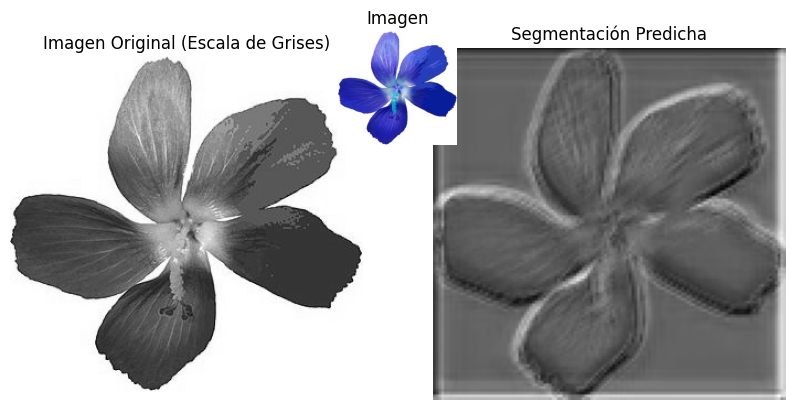

In [ ]:
# =========================================
# IMPORTACIÓN DE LIBRERÍAS
# =========================================
import tensorflow as tf  # Para construir y entrenar la red neuronal
import numpy as np  # Para manipulación de arrays y procesamiento numérico
import cv2  # Para procesamiento de imágenes
import urllib.request  # Para descargar la imagen desde internet
import matplotlib.pyplot as plt  # Para visualizar los resultados
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Input, concatenate
from tensorflow.keras.models import Model  # Para construir el modelo de red neuronal

# =========================================
# 1. DESCARGA AUTOMÁTICA DE UNA IMAGEN DESDE INTERNET
# =========================================
image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3f/JPEG_example_flower.jpg/320px-JPEG_example_flower.jpg"
image_path = "downloaded_image.jpg"

# Descarga la imagen y la guarda en el sistema local
urllib.request.urlretrieve(image_url, image_path)

# =========================================
# 2. CARGA Y PREPROCESAMIENTO DE LA IMAGEN
# =========================================
# Carga la imagen en color (por defecto, OpenCV la carga en formato BGR)
image = cv2.imread(image_path)

# Convierte la imagen a escala de grises para facilitar la segmentación
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Redimensiona la imagen a un tamaño fijo (128x128 píxeles) para que sea compatible con la red U-Net
resized_image = cv2.resize(gray_image, (128, 128))

# Normaliza los valores de los píxeles en un rango de 0 a 1 (dividiendo por 255)
normalized_image = resized_image / 255.0

# Expande las dimensiones para que coincidan con el formato de entrada de la red neuronal (batch_size, altura, ancho, canales)
input_image = np.expand_dims(normalized_image, axis=(0, -1))  # (1, 128, 128, 1)

# =========================================
# 3. DEFINICIÓN DE LA ARQUITECTURA U-NET
# =========================================
def unet_model(input_shape=(128, 128, 1)):
    """
    Construye un modelo U-Net para segmentación de imágenes.

    Parámetros:
    - input_shape: Tamaño de la imagen de entrada (altura, ancho, canales).

    Retorna:
    - Un modelo de red neuronal basado en U-Net.
    """
    inputs = Input(input_shape)

    # CODIFICADOR (ENCODER): Extrae características mediante capas convolucionales
    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)  # Reduce la resolución a la mitad

    conv2 = Conv2D(64, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)  # Reduce la resolución a la mitad nuevamente

    conv3 = Conv2D(128, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(128, (3, 3), activation="relu", padding="same")(conv3)

    # DECODIFICADOR (DECODER): Restaura la resolución de la imagen original
    up1 = UpSampling2D(size=(2, 2))(conv3)  # Duplicamos la resolución
    up1 = concatenate([up1, conv2], axis=-1)  # Concatenamos con la salida del encoder
    conv4 = Conv2D(64, (3, 3), activation="relu", padding="same")(up1)
    conv4 = Conv2D(64, (3, 3), activation="relu", padding="same")(conv4)

    up2 = UpSampling2D(size=(2, 2))(conv4)  # Otra duplicación de la resolución
    up2 = concatenate([up2, conv1], axis=-1)
    conv5 = Conv2D(32, (3, 3), activation="relu", padding="same")(up2)
    conv5 = Conv2D(32, (3, 3), activation="relu", padding="same")(conv5)

    # CAPA DE SALIDA: Genera la segmentación final en escala de grises (valores entre 0 y 1)
    outputs = Conv2D(1, (1, 1), activation="sigmoid")(conv5)

    # Construcción del modelo U-Net
    model = Model(inputs, outputs)
    return model

# =========================================
# 4. CARGA DE UN MODELO ENTRENADO O CREACIÓN DE UNO NUEVO
# =========================================
try:
    # Intentamos cargar un modelo previamente entrenado
    model = tf.keras.models.load_model("unet_model.h5")
    print("Modelo cargado correctamente.")
except:
    print("No se encontró un modelo preentrenado. Se creará uno nuevo.")

    # Si no existe, se crea y compila un nuevo modelo U-Net
    model = unet_model()
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# =========================================
# 5. REALIZAR PREDICCIÓN DE SEGMENTACIÓN SOBRE LA IMAGEN
# =========================================
# Genera una predicción usando el modelo U-Net entrenado
segmented_image = model.predict(input_image)[0, :, :, 0]  # Se obtiene la imagen segmentada

# =========================================
# 6. VISUALIZACIÓN DE RESULTADOS
# =========================================
plt.figure(figsize=(10, 5))

# Muestra la imagen original en escala de grises
plt.subplot(1, 2, 1)
plt.title("Imagen Original (Escala de Grises)")
plt.imshow(gray_image, cmap="gray")
plt.axis("off")

# Muestra la imagen segmentada obtenida por la red U-Net
plt.subplot(1, 2, 2)
plt.title("Segmentación Predicha")
plt.imshow(segmented_image, cmap="gray")
plt.axis("off")

# Muestra la imagen original
plt.subplot(3, 2, (1, 2))
plt.title("Imagen")
plt.imshow(image)
plt.axis("off")

# Mostrar ambas imágenes en pantalla
plt.show()
